# (Bayesian) Naive Bayes algorithm

In [33]:
import pymc3 as pm
import theano as tt
import numpy as np
from sklearn import datasets
%matplotlib inline

## Definition

The Naive Bayes algorithm is a classification algorithm that is often used in topic classification for textual data. Imagine a situation where we have $n_{features}$ documents, each represented by a vector $\vec{x}$ where $x_i$ is the number of times that the word $i$ appears in the document (bag-of-word representation). The quantity we want to estimate is the probability that the document $i$ belongs to a class $c$ given the data $\mathcal{D}$:

$$P( y = c | \mathbf{x}, \mathcal{D})$$

Following `Bayes` rule we can write:

$$P(y = c | \mathbf{x}, \mathcal{D}) \sim P(\mathbf{x}| y = c, \mathcal{D})\;P(y=c|\mathcal{D})$$

The `Naive` part of the algorithm is to write that the random variables describing each component of the vector $\mathbf{x}$ are independant:

$$P(\mathbf{x}|y=c) = \prod_{j=1}^{n_{dims}} P(x_j | y=c)$$

This, of course, is a coarse approximation: it is--for instance--more likely that the word `computer` will occur often in a document that contains the word `email` often than the word `leek`. There are correlations between the different components. But, surprisingly, this simplified model is very effective.

## Model

Statistically, for continuous data, the Naive Bayes model can be defined as: 

$$\mathbf{\alpha} = [1, \dots, 1]$$
$$\mathbf{\pi} \sim Dirichlet\left(\mathbf{\alpha}\right)$$
$$z \sim Cat(\pi)$$
$$x_{jc} \sim Normal\left(\mu_{jc}, \sigma_{jc}\right)$$

## Model

In [2]:
iris = datasets.load_iris()

In [3]:
# Define as theano shared variables so the value can be changed later on
X = tt.shared(iris.data)
y = tt.shared(iris.target)

n_dims = iris.data.shape[1]
n_classes = len(set(iris.target))
n_features = iris.data.shape[0]

In [4]:
with pm.Model() as model:
    # Priors
    alpha = np.ones(n_classes)
    pi = pm.Dirichlet('pi', alpha, shape=n_classes)
    mu = pm.Normal('mu', 0, 100, shape=(n_classes, n_dims))
    sigma = pm.HalfNormal('sigma', 100, shape=(n_classes, n_dims))
    
    # Assign class to data points
    z = pm.Categorical('z', pi, shape=n_features, observed=y)
    
    # The components are independent and normal-distributed
    a = pm.Normal('a', mu[z], sigma[z], observed=X)

In [5]:
%timeit
with model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 513.4:  18%|█▊        | 35778/200000 [00:07<00:33, 4964.63it/s]  
Convergence archived at 36100
Interrupted at 36,100 [18%]: Average Loss = 1,376.9
100%|██████████| 5500/5500 [00:14<00:00, 371.21it/s]


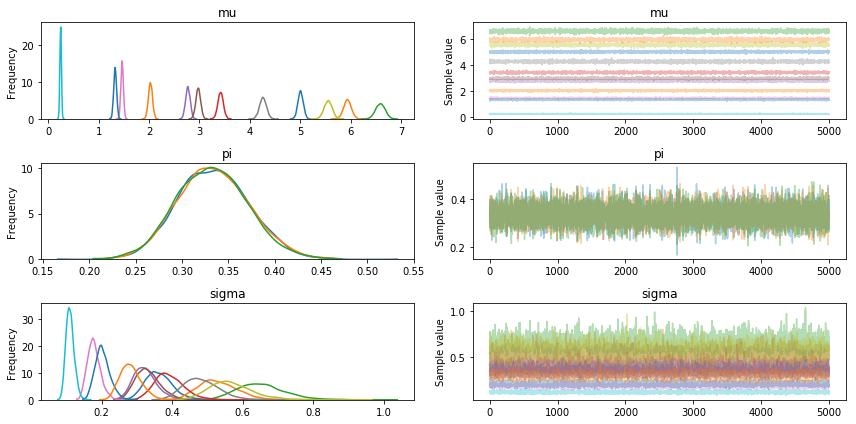

In [6]:
_ = pm.traceplot(trace)

### Evaluation metrics

We need several evaluation metrics to decide whether the chains have converged.

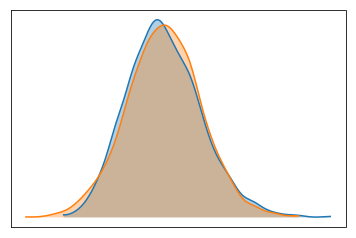

In [7]:
pm.energyplot(trace, legend=False, figsize=(6, 4))

## Prediction time!

Prediction for Bayesian models are slightly different from their frequentist counterpart, they require to evaluate many integrals over the parameters. Given a data point $\mathbf{x} = {x_j}$, we would like to estimate the probability that it belongs to any category $c$. Following the notations in [1], the probability reads:

$$
P(y=c | \mathbf{x}, \mathcal{D}) = P(y=c|\mathcal{D}) \prod_{j=1}^{dims} P(x_j | y=c, \mathcal{D})
$$

The data $\mathcal{D}$ helped us estimate the distribution of the parameter $\mathbf{\mu}$, $\mathbf{\pi}$ and $\mathbf{\sigma}$. We now need to integrate over the values of these parameters:

$$
P(y=c | \mathbf{x}, \mathbf{D}) = \left[\int Cat(y=c|\pi) P(\pi|\mathcal{D}) \mathrm{d}\mathbf{\pi}\right] \prod_{j=1}^{dims} Normal(x_j | \mu_{jc}, \sigma_jc) P(\mu_{jc}|\mathcal{D}) P(\sigma_{jc} | \mathcal{D})
$$

which can be evaluated from the samples we previously computed (show).

In [10]:
import itertools as it
import operator
import functools as ft
import scipy.stats

def normalize(array):
    """ Normalize the number in an array to get probabilities.
    """
    return array/np.sum(array)
    

def predict(trace, X):
    """ Predict the probabilities that the data points belong to a class. """
    n_dims = X.shape[1]
    
    predictions = np.array([])
    for x in X:
        normal_probs = scipy.stats.norm(trace['mu'], trace['sigma']).pdf(x)
        per_dim = [np.sum(normal_probs[:,:,i], axis=0)/len(trace['mu']) for i in range(n_dims)]
        a = normalize(ft.reduce(lambda x,y: x*y, per_dim))
        a[np.abs(a) < 0.00001] = 0
        if len(predictions) == 0:
            predictions = a
        else:
            predictions = np.vstack((predictions,a))
    return predictions

pred = predict(trace, iris.data)

pred_class = np.argmax(pred, axis=1)
print(iris.target)
print(pred_class)
print(sum(np.equal(pred_class, iris.target))/len(iris.data))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
0.9533333333333334


## Loss functions

*Zero one loss function*

$$ \lambda = 1 if i \neq j and 0 otherwise $$

We can show that this leads to choosing the class that has the highest probability. We may however find that we occur a larger loss when we choose such or such category, and act accordingly.

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
import sys
from sklearn import datasets
import pymc3 as pm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pymc3_models.models.NaiveBayes import GaussianNaiveBayes

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Define as theano shared variables so the value can be changed later on
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [3]:
N = GaussianNaiveBayes()

In [4]:
N.fit(X, y) # N.infer(X_control, X_variant1, X_variant3)

Average Loss = 512.04: 100%|██████████| 200000/200000 [02:16<00:00, 1461.65it/s]
Finished [100%]: Average Loss = 512.04


GaussianNaiveBayes()

In [5]:
pred = N.predict_proba(X)
150 - N.score(X,y)*150

7.0

Get the misclassified examples and compare to the entropy.

In [65]:
a = -np.sum(pred*np.log(pred), axis=1)
print(a)

[9.09382176e-13 7.37158447e-12 1.18366405e-12 5.02948165e-12
 3.67255849e-13 4.09384805e-10 2.84039262e-12 2.28470997e-12
 5.80853140e-12 3.33186024e-12 1.98409443e-12 3.62376064e-12
 2.20080579e-12 9.91876794e-13 9.93114622e-13 1.51135806e-11
 1.52049392e-11 5.19467692e-12 2.88721978e-10 1.83197153e-12
 1.04126302e-10 3.90033637e-11 1.69489623e-13 7.69320218e-08
 3.43668623e-10 5.11432119e-11 4.12911537e-10 2.61167646e-12
 2.34380942e-12 9.09681490e-12 1.85397350e-11 7.50161521e-10
 3.31290389e-14 1.03680187e-13 3.33186024e-12 2.17496048e-12
 3.55950512e-12 3.33186024e-12 2.48565406e-12 3.17727107e-12
 2.55248528e-12 1.65768994e-10 8.90587221e-13 1.82223717e-07
 5.45163944e-09 3.31734817e-11 8.53637833e-13 1.50664028e-12
 1.25492239e-12 2.03108275e-12 5.20975916e-01 2.48651823e-01
 6.89887865e-01 9.14698574e-04 2.22428549e-01 1.19049853e-02
 6.45432358e-01 4.74185034e-05 7.86053026e-02 2.23607452e-03
 4.14038314e-05 3.67957920e-02 3.67795934e-04 9.48854283e-02
 1.00700653e-03 1.294422

In [6]:
N.trace

<MultiTrace: 1 chains, 10000 iterations, 5 variables>

In [7]:
_ = pm.traceplot(N.trace)